In [28]:
import asyncio
import enact

from async_api import Game, PolicyAPI
import policies
#from policies import AimAt, ChangeAim

In [29]:
api = PolicyAPI(policies.ChangeAim())
game = Game(api)
with enact.InMemoryStore() as store:
  with api.connect_to(game):
    invocation, _ = await asyncio.gather(api.invoke(), game.game_loop())


Calling ChangeAim.
Counter: 0


In [30]:
step_invocation = invocation.get_child(0).get_child(0).get_child(0)
step_invocation.request().invokable()

Step()

In [31]:
step_invocation

Invocation(request=<Ref: edb02105415400bd7e476dfdf84ac7df19a4c993c471c6d50e775da593763a24>, response=<Ref: c7a2927c6b28e99d82b88537a7e12d30bde9266bbd698e72ee1b580884773adc>)

In [35]:
import numpy as np
from async_api import Step
from typing import Optional
import matplotlib.pyplot as plt

def get_observations(i: enact.Invocation, aim_target: Optional[list]=None):
  if aim_target is None:
    aim_target = [[0., 0.]]
  if isinstance(i.request().invokable(), Step):
    yield [*i.response().output().value.tolist(), aim_target]
  elif isinstance(i.request().invokable(), policies.AimAt):
    aim_target = i.request().invokable().target
  for c in i.get_children():
    yield from get_observations(c, aim_target)

with store:
  obs_list = list(get_observations(invocation))
  position = np.array([o[0] for o in obs_list])
  goal = np.array([o[1][0] for o in obs_list])
  print(f'Position Shape: {position.shape}')
  print(f'Goal Shape: {goal.shape}')

Position Shape: (301, 2)
Goal Shape: (301, 2)


(0.0, 25.0)

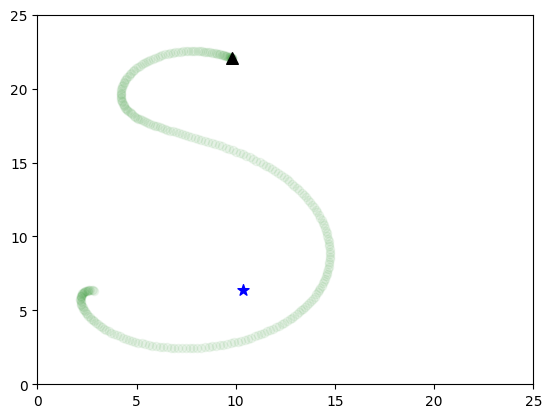

In [36]:
plt.scatter(position[:, 0], position[:, 1], alpha=0.05, c='g')
plt.scatter(position[0, 0], position[0, 1], c='k', marker='^', s=70, alpha=1)
plt.scatter(goal[0, 0], goal[0, 1], marker='*', s=70, c='b')
plt.xlim((0, 25))
plt.ylim((0, 25))

Text(0.5, 1.0, 'Generated Policy Actions')

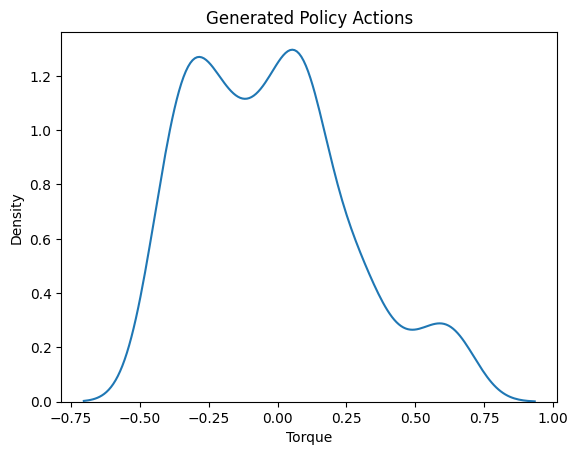

In [38]:
import seaborn as sns

from async_asteroids import Action

def get_actions(i: enact.Invocation, action: Optional[Action]=None):
  if isinstance(i.request().invokable(), Step):
    yield [i.request().input()]
  for c in i.get_children():
    yield from get_actions(c, action)

with store:
  actions_list = list(get_actions(invocation))
  actions_list = [a[0] for a in actions_list]

torque_vals = [a.torque for a in actions_list]
thrust_vals = [a.thrust for a in actions_list]

sns.kdeplot(np.array(torque_vals))
plt.xlabel('Torque')
plt.title('Generated Policy Actions')